# 2D Preprocessing the GlobColour Dataset 
* prepare dataset for LDS-fitting:
   * load all 5 variables and merge (interpolate) with the float dataset
   * load the distance to coast and merge (interpolate) with the float dataset
   * output the data on disk
   * (plan)if needed, split Nov-Dec, encoding the weekly number

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt
from dask.diagnostics import ProgressBar
import seaborn as sns
from matplotlib.colors import LogNorm

In [2]:
# resampling frequency in number of days
freq=2

In [3]:
''' SST is not from GlobColor
from tools.load_GlobColor_dataset import load_dataset
import importlib
importlib.reload(load_dataset)
############### T865
ds_daily = load_dataset.load_t865()
'''

' SST is not from GlobColor\nfrom tools.load_GlobColor_dataset import load_dataset\nimport importlib\nimportlib.reload(load_dataset)\n############### T865\nds_daily = load_dataset.load_t865()\n'

## Load data from disk
We already downloaded a subsetted MODIS-Aqua dataset for the Arabian Sea.
We can read all the netcdf files into one xarray Dataset using the open_mfsdataset function. Note that this does not load the data into memory yet. That only happens when we try to access the values.

In [11]:
#ds_8day = xr.open_mfdataset('./data_collector_modisa_chla9km/ModisA_Arabian_Sea_chlor_a_9km_*_8D.nc')
ds_daily = xr.open_mfdataset('./data_collector_modisa_NSST4mu_4km_tomatchHermes/ModisA_Arabian_Sea_SST4_sst4_4km_*D.nc')
#both_datasets = [ds_8day, ds_daily]

In [12]:
ds_daily = ds_daily.drop(['palette','qual_sst4'])

In [13]:
ds_daily.var

<bound method ImplementsDatasetReduce._reduce_method.<locals>.wrapped_func of <xarray.Dataset>
Dimensions:  (lat: 552, lon: 720, time: 5539)
Coordinates:
  * lat      (lat) float64 27.98 27.94 27.9 27.85 27.81 27.77 27.73 27.69 ...
  * lon      (lon) float64 45.02 45.06 45.1 45.15 45.19 45.23 45.27 45.31 ...
  * time     (time) datetime64[ns] 2002-07-04 2002-07-05 2002-07-06 ...
Data variables:
    sst4     (time, lat, lon) float64 nan nan nan nan nan nan nan nan nan ...
Attributes:
    product_name:                      A2002185.L3m_DAY_SST4_sst4_4km.nc
    instrument:                        MODIS
    title:                             HMODISA Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          Aqua
    temporal_range:                    15-hour
    processing_version:                2014.0.1
    date_created:                      2017-05-08T12:15:57.000Z
    history:                     

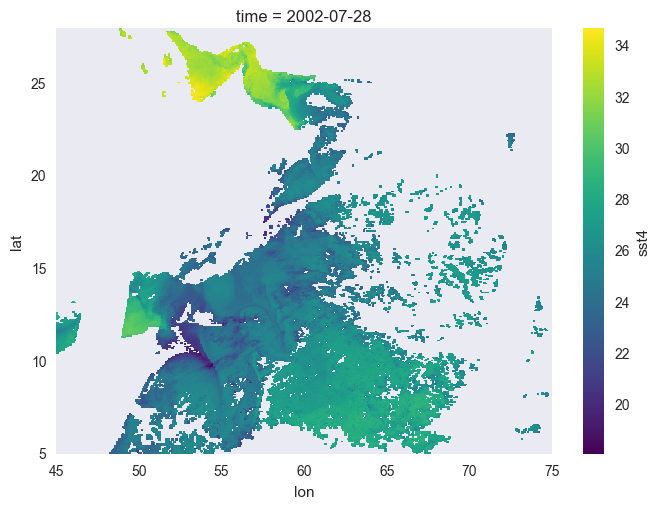

In [16]:
ds_daily.sst4.sel(time='2002-07-28').plot()

In [17]:
freq_resample = str(8) + 'D'
ds_8day = ds_daily.resample(freq_resample, dim='time')  # see the above for doc, test case, & default behavior
ds_8day

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/dask/array/numpy_compat.py:45: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.Dataset>
Dimensions:  (lat: 552, lon: 720, time: 693)
Coordinates:
  * lat      (lat) float64 27.98 27.94 27.9 27.85 27.81 27.77 27.73 27.69 ...
  * lon      (lon) float64 45.02 45.06 45.1 45.15 45.19 45.23 45.27 45.31 ...
  * time     (time) datetime64[ns] 2002-07-04 2002-07-12 2002-07-20 ...
Data variables:
    sst4     (time, lat, lon) float64 nan nan nan nan nan nan nan nan nan ...

In [18]:
# check data quality
both_datasets = [ds_8day, ds_daily]
print([(ds.nbytes / 1e6) for ds in both_datasets])

[2203.42308, 17611.415768]


In [ ]:
'''
# no need for termperature, sst can be <0
def fix_bad_data(ds):
    # for some reason, the cloud / land mask is backwards on some data
    # this is obvious because there are t865 values less than zero
    bad_data = ds.t865.groupby('time').min() < 0
    # loop through and fix
    for n in np.nonzero(bad_data.values)[0]:
        data = ds.t865[n].values 
        ds.t865.values[n] = np.ma.masked_less(data, 0).filled(np.nan)
[fix_bad_data(ds) for ds in both_datasets]
'''

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/dask/array/numpy_compat.py:45: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


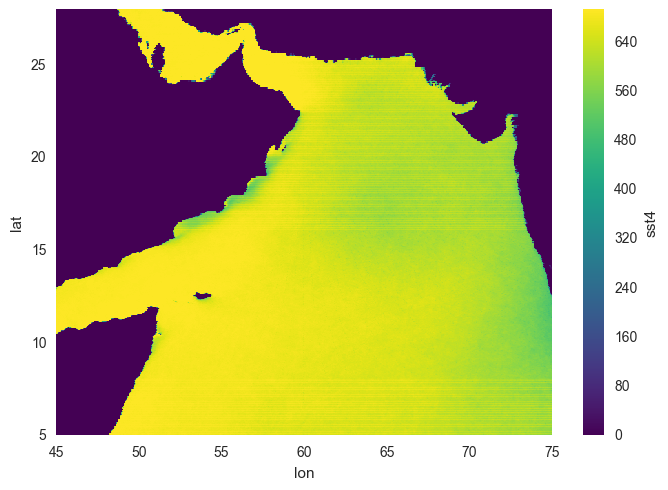

In [21]:
# Count the number of ocean data points
(~ds_8day.sst4.isnull()).sum(dim='time').plot()

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/dask/array/numpy_compat.py:45: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


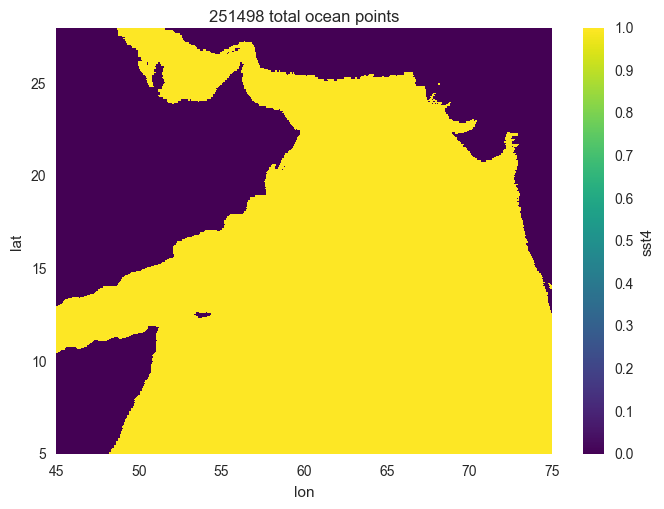

In [39]:
#  find a mask for the land
ocean_mask = ((~ds_8day.sst4.isnull()).sum(dim='time'))>1
num_ocean_points = ocean_mask.sum().values
ocean_mask.plot()
plt.title('%g total ocean points' % num_ocean_points)

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/matplotlib/colors.py:1022: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


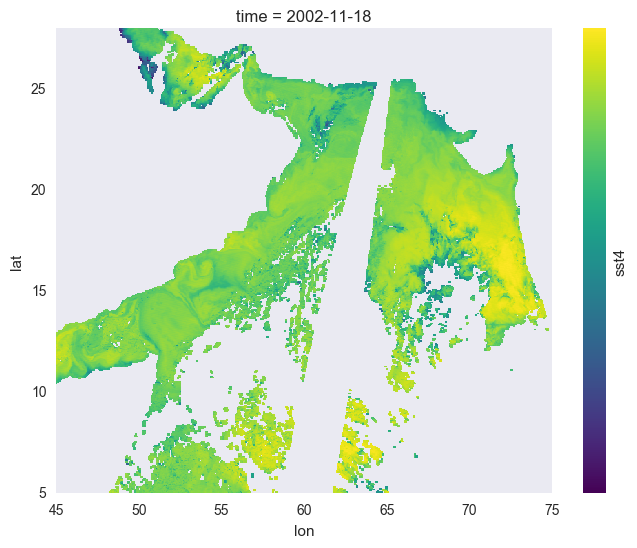

In [30]:
plt.figure(figsize=(8,6))
ds_daily.sst4.sel(time='2002-11-18',method='nearest').plot(norm=LogNorm())

In [46]:
(~ds_daily.sst4.isnull()).sum(['lat','lon']) # information from original data

<xarray.DataArray 'sst4' (time: 5539)>
array([     0,  93356, 111044, ...,  53633,  70480,  72927])
Coordinates:
  * time     (time) datetime64[ns] 2002-07-04 2002-07-05 2002-07-06 ...

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/dask/array/numpy_compat.py:45: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


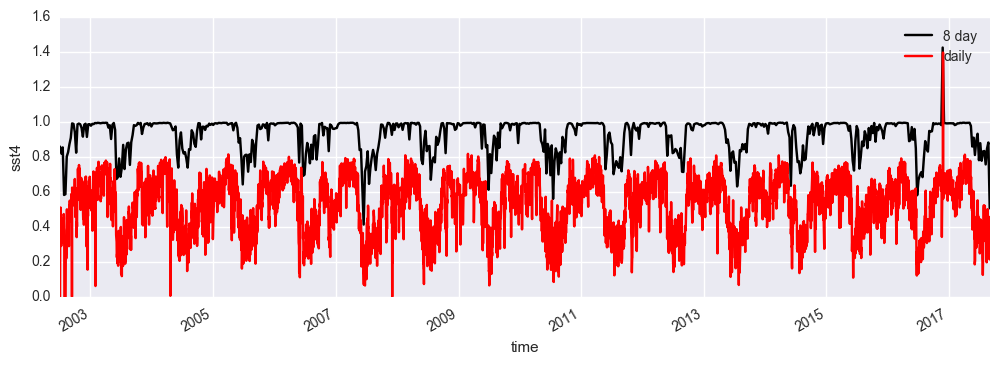

In [47]:
count_8day,count_daily = [(~ds.sst4.isnull()).sum(['lat','lon'])/float(num_ocean_points)
                            for ds in (ds_8day,ds_daily)]

plt.figure(figsize=(12,4))
count_8day.plot(color='k')
count_daily.plot(color='r')

plt.legend(['8 day','daily'])    # there is one day in the datset have SST values on the land !

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/dask/array/numpy_compat.py:45: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


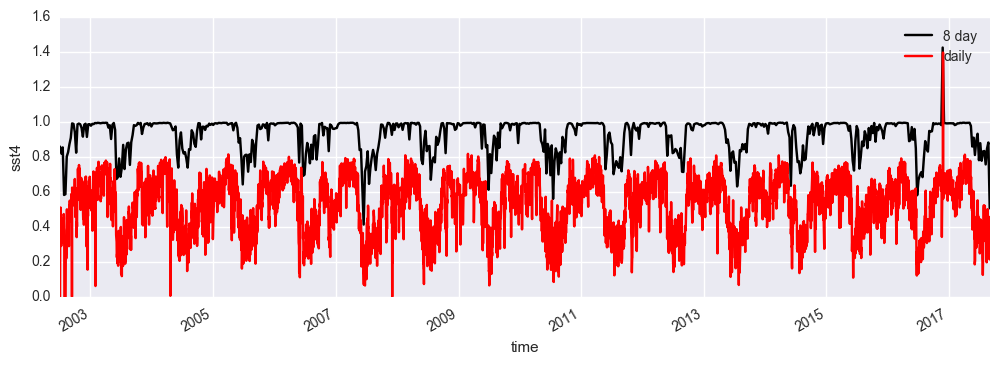

In [43]:
count_8day,count_daily = [ds.sst4.groupby('time').count()/float(num_ocean_points)
                            for ds in (ds_8day,ds_daily)]

plt.figure(figsize=(12,4))
count_8day.plot(color='k')
count_daily.plot(color='r')

plt.legend(['8 day','daily'])    # there is one day in the datset have SST values on the land !

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/dask/array/numpy_compat.py:45: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


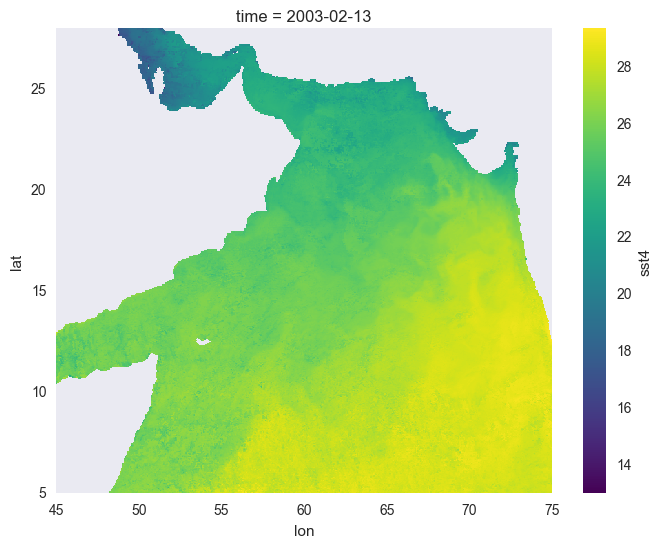

In [52]:
# Maps of individual days
target_date = '2003-02-15'
plt.figure(figsize=(8,6))
ds_8day.sst4.sel(time=target_date, method='nearest').plot()

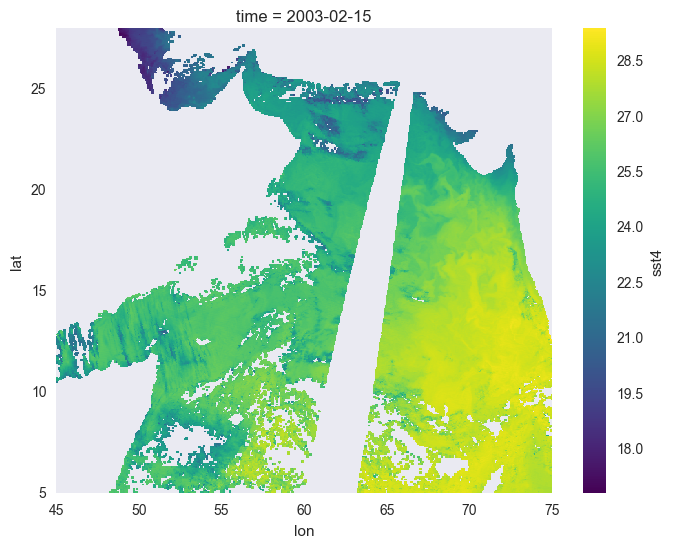

In [51]:
plt.figure(figsize=(8,6))
ds_daily.sst4.sel(time=target_date, method='nearest').plot()

In [53]:
freq

2

In [54]:
# next carry out interpolation starts here
freq_resample = str(freq) + 'D'
ds_resample = ds_daily.resample(freq_resample, dim='time')  # see the above for doc, test case, & default behavior
ds_resample

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/dask/array/numpy_compat.py:45: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.Dataset>
Dimensions:  (lat: 552, lon: 720, time: 2770)
Coordinates:
  * lat      (lat) float64 27.98 27.94 27.9 27.85 27.81 27.77 27.73 27.69 ...
  * lon      (lon) float64 45.02 45.06 45.1 45.15 45.19 45.23 45.27 45.31 ...
  * time     (time) datetime64[ns] 2002-07-04 2002-07-06 2002-07-08 ...
Data variables:
    sst4     (time, lat, lon) float64 nan nan nan nan nan nan nan nan nan ...

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/dask/array/numpy_compat.py:45: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


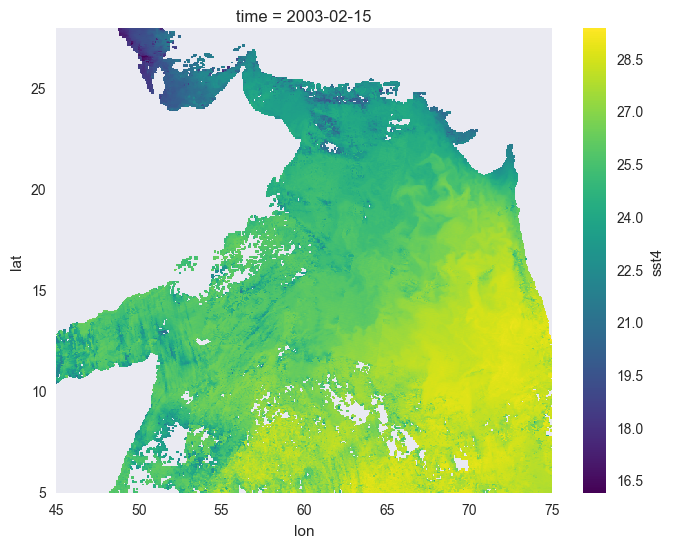

In [55]:
plt.figure(figsize=(8,6))
ds_resample.sst4.sel(time=target_date, method='nearest').plot()

In [56]:
# check the range for the longitude
print(ds_resample.lon.min(),'\n' ,ds_resample.lat.min())  

<xarray.DataArray 'lon' ()>
array(45.02083206176758) 
 <xarray.DataArray 'lat' ()>
array(5.0208306312561035)


In [ ]:
ds_resample.load()

# ++++++++++++++++++++++++++++++++++++++++++++++
# All GDP Floats
# Load the float data
# Map a (time, lon, lat) to a value on the cholorphlly value

In [48]:
# load preprocessed float data, and start the interpolation right here!!!!
var5 = "par"
var4 = "t865"
var3 = "kd490"
var2 = "cdm"
var1 = "chl"
vardist = "dist"

indir_prefix = "./data_globcolour/output.data/interpolate/" + "df_Globcolor_"
indir = indir_prefix + var1 + vardist + var2 + var3 + var4 + var5 + "_" + str(freq) + "d.csv"

floatDF_tmp = pd.read_csv(indir,index_col=0)
print(floatDF_tmp)

             id        time        lat        lon       temp          ve  \
2556      10206  2002-07-04  16.229625  66.330375        NaN   13.064500   
5112      10208  2002-07-04  13.891875  69.552375        NaN    8.505125   
7668      11089  2002-07-04  16.354375  64.683750  27.954125   12.168000   
10224     15703  2002-07-04  13.903250  69.583125  28.552250    8.685875   
15336     27069  2002-07-04  20.169750  68.737500  29.012000   26.958750   
20448     28842  2002-07-04  18.878875  60.694625  27.701750   10.499125   
23004     34159  2002-07-04  12.548125  58.914250        NaN   27.354250   
28116     34210  2002-07-04   6.476750  56.925000  26.694875   -9.666750   
30672     34211  2002-07-04   8.602375  67.929125  28.278000   20.618125   
33228     34212  2002-07-04   6.232000  64.750250  28.470750   14.641875   
53676     34708  2002-07-04  10.167500  59.691500  27.185500   47.792000   
58788     34710  2002-07-04  12.933625  49.905250  30.910625  -34.754625   
61344     34

In [72]:
import importlib
from tools.time_lat_lon_interpolate import interpolate
importlib.reload(interpolate)

result_out5 = interpolate.sel_points_multilinear_time_lat_lon(ds_resample, floatDF_tmp, dims = 'points', col_name ='sst4')
print('\n *** after the interpolation *** \n', result_out5)
# important: keep the id, since the dataframe has been modified in a bound-aware way in the function
print('\n *** this two length should be equal *** %d >= %d?' %(len(floatDF_tmp.index), len(result_out5.index) ) )  

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/dask/array/numpy_compat.py:45: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)



 *** after the interpolation *** 
              id        time        lat        lon       temp          ve  \
2556      10206  2002-07-04  16.229625  66.330375        NaN   13.064500   
5112      10208  2002-07-04  13.891875  69.552375        NaN    8.505125   
7668      11089  2002-07-04  16.354375  64.683750  27.954125   12.168000   
10224     15703  2002-07-04  13.903250  69.583125  28.552250    8.685875   
15336     27069  2002-07-04  20.169750  68.737500  29.012000   26.958750   
20448     28842  2002-07-04  18.878875  60.694625  27.701750   10.499125   
23004     34159  2002-07-04  12.548125  58.914250        NaN   27.354250   
28116     34210  2002-07-04   6.476750  56.925000  26.694875   -9.666750   
30672     34211  2002-07-04   8.602375  67.929125  28.278000   20.618125   
33228     34212  2002-07-04   6.232000  64.750250  28.470750   14.641875   
53676     34708  2002-07-04  10.167500  59.691500  27.185500   47.792000   
58788     34710  2002-07-04  12.933625  49.905250  3

/Users/vyan2000/local/miniconda3/envs/condapython3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


             id        time        lat        lon       temp          ve  \
2556      10206  2002-07-04  16.229625  66.330375        NaN   13.064500   
5112      10208  2002-07-04  13.891875  69.552375        NaN    8.505125   
7668      11089  2002-07-04  16.354375  64.683750  27.954125   12.168000   
10224     15703  2002-07-04  13.903250  69.583125  28.552250    8.685875   
15336     27069  2002-07-04  20.169750  68.737500  29.012000   26.958750   
20448     28842  2002-07-04  18.878875  60.694625  27.701750   10.499125   
23004     34159  2002-07-04  12.548125  58.914250        NaN   27.354250   
28116     34210  2002-07-04   6.476750  56.925000  26.694875   -9.666750   
30672     34211  2002-07-04   8.602375  67.929125  28.278000   20.618125   
33228     34212  2002-07-04   6.232000  64.750250  28.470750   14.641875   
53676     34708  2002-07-04  10.167500  59.691500  27.185500   47.792000   
58788     34710  2002-07-04  12.933625  49.905250  30.910625  -34.754625   
61344     34

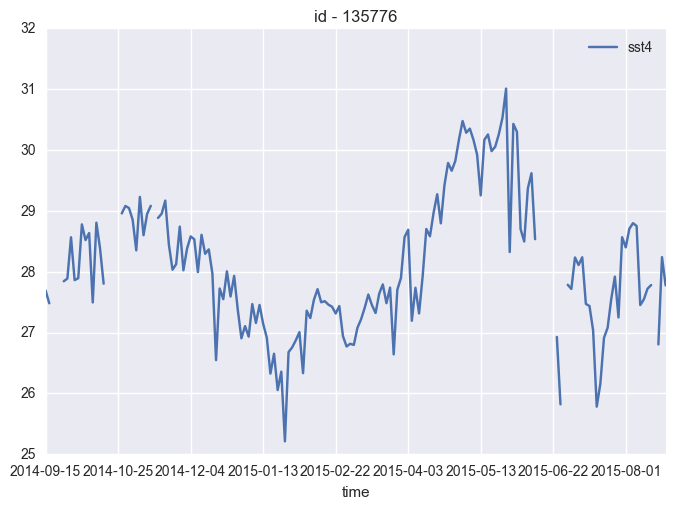

In [73]:
# output the dataframe result_out4
var6 = "sst4"
outdir_prefix = "./data_globcolour/output.data/interpolate/" + "df_Globcolor_"
outdir = outdir_prefix + var1 + vardist + var2 + var3 + var4 + var5 + var6 +"_" + str(freq) + "d.csv"
result_out5.to_csv(outdir)
print(pd.read_csv(outdir,index_col=0))

### plot for id 125776, which will be fit by LDS
plt.figure(figsize=(8,6))
result_out5[result_out5.id == 135776].plot(x='time', y ='sst4', title=('id - %d' % 135776) )
plt.show();
plt.close("all")